<h1 align="center"> Enhancing network forensic mechanism for SQL injection activities on web applications based on ensemble machine learning algorithm</h1>

## 1. Load SQL Injection Datasets

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)

In [2]:
data = pd.read_csv("sqli.csv", encoding="UTF-16 LE")

## 3. Data Exploration

In [3]:
# Show a random sample of 5 rows from the data
data.sample(5)

,Sentence,Label
2344,"There major problems , primarily terms coveri...",0
1050,""" ) or benchmark ( 10000000,MD5 ( 1 ) ) #",1
1205,There class persons spiritual affinity I boug...,0
1975,He admitted cocaine possession earlier hearing,0
2378,We testing past months seemed perfect share H...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  4187 non-null   object
 1   Label     4200 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 65.8+ KB


## 4. Data Wrangling

### 4.1. Clean Erroneous Label

In [5]:
data.Label.unique()[:10]

array([1, 0], dtype=int64)

We need to clean some data points which contain labels which are neither 0 nor 1

In [6]:
correct_labels = [1, 0, '1', '0']

In [7]:
data = data[data['Label'].isin(correct_labels)]

In [8]:
# Check if every incorrect labels have been dropped
data.Label.unique()

array([1, 0], dtype=int64)

In [9]:
# map label for consistency
data['Label'] = data['Label'].replace({'1': 1, '0': 0})

### 4.3. Drop NaNs

In [10]:
data = data.dropna()

In [11]:
# Confirm all NaNs have been drop
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4187 entries, 0 to 4199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  4187 non-null   object
 1   Label     4187 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 98.1+ KB


## 5. Data Visualization

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### 5.1. Proportion of Injections to Non Injections

In [13]:
label_mapping = {1: 'Injection', 0: 'Non Injection'}

C:\Users\Merit Dev\AppData\Local\Temp\ipykernel_7144\3993624353.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=data, palette='Set2')


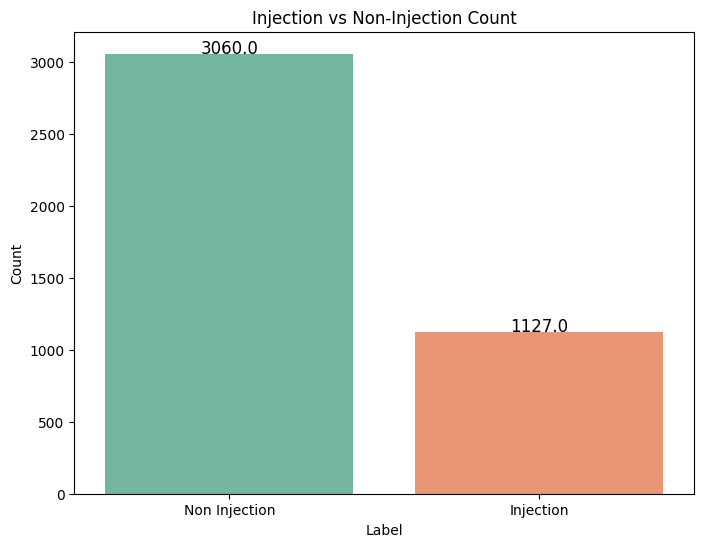

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=data, palette='Set2')

# Add count annotations on each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='baseline', color='black', fontsize=12)

# Set plot labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Injection vs Non-Injection Count')

# Replace x-axis ticks with meaningful names
plt.xticks(ticks=[0, 1], labels=[label_mapping[label] for label in sorted(data['Label'].unique())])

plt.show()

### 5.2. Plot frequent words used in Injections and Non-Injections

In [15]:
def wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

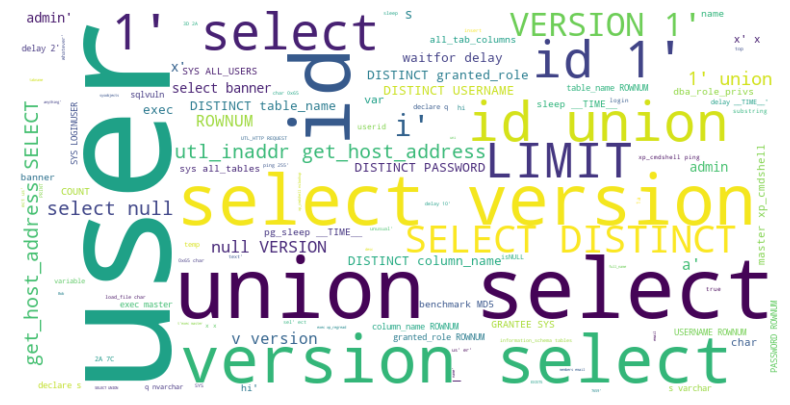

In [16]:
injections = ' '.join(data[data['Label'] == 1]['Sentence'])

wordcloud(injections)

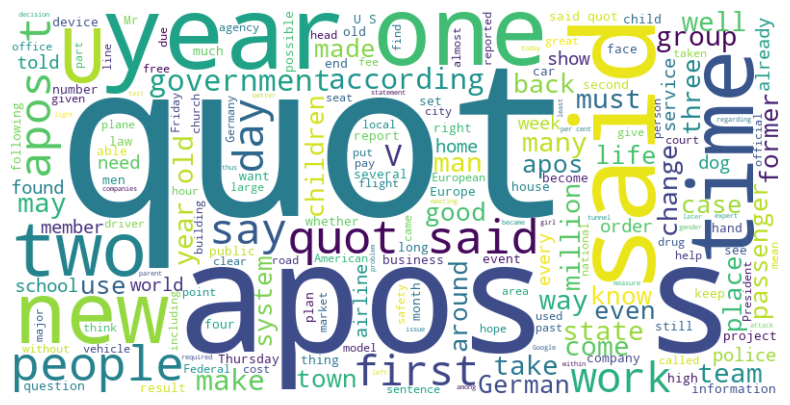

In [17]:
non_injections = ' '.join(data[data['Label'] == 0]['Sentence'])

wordcloud(non_injections)

## 5. Data Vectorization

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
vectorizer = TfidfVectorizer()

In [20]:
X = vectorizer.fit_transform(data['Sentence'])
y = data['Label']

## 6. Split Data into Training and Test Set

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## 7. Define Evaluation Metrics

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

In [24]:
def plot_confusion_matrix(conf_matrix):
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [25]:
def plot_roc_curve(classifier, X_test, y_test):
    y_prob = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

## 8. Model Building

In [26]:
def train_and_evaluate_classifier(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return y_pred, accuracy, precision, recall, f1, conf_matrix

In [27]:
def evaluate_classifier(classifier, X_train, X_test, y_train, y_test, metrics):
    
    print(f'Accuracy: {metrics[0]:.2f}')
    print(f'Precision: {metrics[1]:.2f}')
    print(f'Recall: {metrics[2]:.2f}')
    print(f'F1-Score: {metrics[3]:.2f}')

    plot_confusion_matrix(metrics[4])
    plot_roc_curve(classifier, X_test, y_test)
    

### 8.1. Naive Bayes Model

In [28]:
from sklearn.naive_bayes import MultinomialNB

In [29]:
# Naive Bayes Classifier
nb_classifier = MultinomialNB()

In [30]:
y_pred_nb, *metrics = train_and_evaluate_classifier(nb_classifier, X_train, X_test, y_train, y_test)

Accuracy: 0.96
Precision: 0.99
Recall: 0.88
F1-Score: 0.93


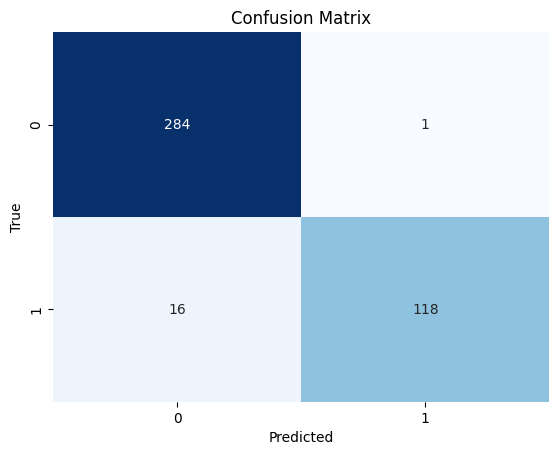

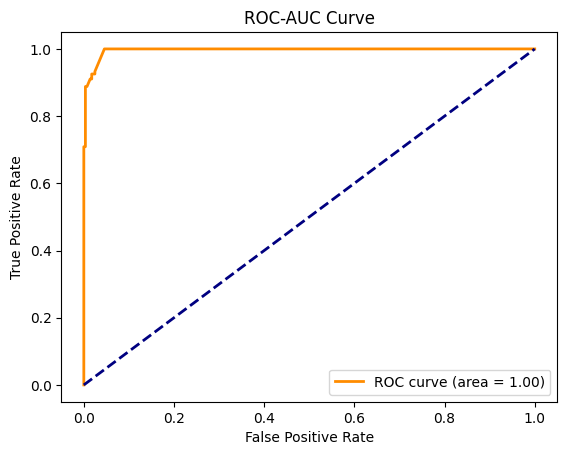

In [31]:
evaluate_classifier(nb_classifier, X_train, X_test, y_train, y_test, metrics)

### 8.1. Support Vector Machine Model

In [32]:
from sklearn.svm import SVC

In [33]:
svm_classifier = SVC(probability=True, random_state=42)

In [34]:
y_pred_svm, *metrics = train_and_evaluate_classifier(svm_classifier, X_train, X_test, y_train, y_test)

Accuracy: 0.97
Precision: 0.95
Recall: 0.95
F1-Score: 0.95


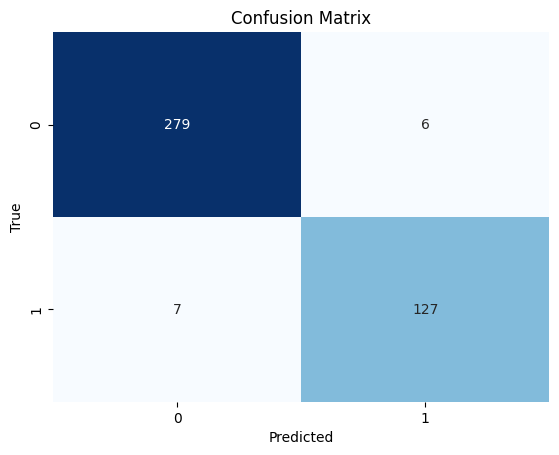

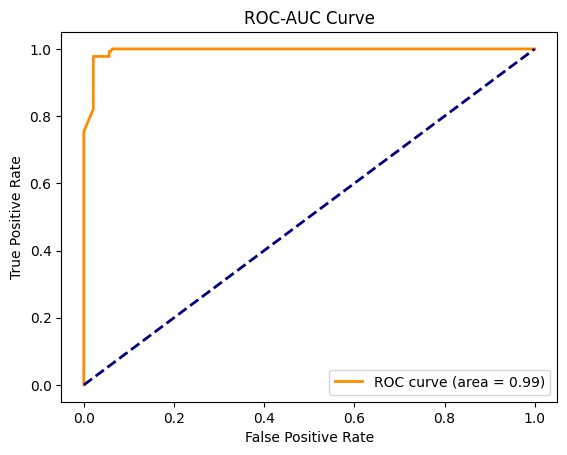

In [35]:
evaluate_classifier(svm_classifier, X_train, X_test, y_train, y_test, metrics)

### 8.3. Ensemble Model

In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [40]:
# Create the ensemble model
esm_clf = VotingClassifier(
    estimators=[('nb', nb_classifier), ('svm', svm_classifier)],
    voting='soft'
)

In [ ]:
# Fit the ensemble model
y_pred_nb, *metrics = train_and_evaluate_classifier(esm_clf, X_train, X_test, y_train, y_test)

In [ ]:
evaluate_classifier(esm_clf, X_train, X_test, y_train, y_test, metrics)

## 9. Save Model

In [ ]:
import joblib

In [ ]:
model = {
    'vectorizer': vectorizer,
    'nb_classifier': nb_classifier,
    'ensemble_classifier': esm_clf
}

In [ ]:
joblib.dump(model, 'model.joblib')